# Initial Setup 

In [333]:
import pandas as pd 
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [624]:
df = pd.read_csv("../raw_data/data/BDI/cleaned_daily_BDI.csv")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

df.head(2)

,Price
Date,
1995-01-03,1964.0
1995-01-04,1961.0


# Scaling the dataset & manual Holdout method

### Holdout method

Train/val/test split = (7:2:1)

In [625]:
input_length = len(df)

In [626]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [627]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [628]:
len(df_train)

4000

In [629]:
len(df_test)

1000

# TimeseriesGenerator for sequences

In [630]:
X_train = df_train
y_train = df_train["Price"]

X_test  = df_test
y_test = df_test["Price"]

In [631]:
scaler = MinMaxScaler()

In [577]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)


In [578]:
# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.fit_transform(y_test)

In [673]:
generator = TimeseriesGenerator(X_train, y_train, length=7, batch_size=6, sampling_rate=1, stride=1)

In [674]:
generator_val = TimeseriesGenerator(X_test, y_test, length=7, batch_size=6, sampling_rate=1, stride=1)

In [675]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    break

(6, 7, 1) (6,)
[[1964.]
 [1961.]
 [1967.]
 [1983.]
 [1994.]
 [2015.]
 [2019.]] 2038.0


# The model

In [676]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [677]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [678]:
rmsprop = RMSprop(learning_rate=lr_schedule)
adam = Adam(learning_rate=0.01)

In [680]:
def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(400, activation="tanh", input_shape=(6,7,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training & Testing 

In [681]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)

In [682]:
model = init_model()

ValueError: Input 0 of layer "lstm_61" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 6, 7, 1)

In [683]:
history = model.fit(
    generator, epochs=100, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/100
666/666 [==============================] - 7s 10ms/step - loss: 5772242.0000 - mae: 1480.2317 - val_loss: 1135709.0000 - val_mae: 994.3110
Epoch 2/100
666/666 [==============================] - 7s 10ms/step - loss: 4528342.0000 - mae: 1434.4114 - val_loss: 1492685.3750 - val_mae: 1167.6268
Epoch 3/100
666/666 [==============================] - 7s 10ms/step - loss: 3886257.0000 - mae: 1304.6531 - val_loss: 1155653.0000 - val_mae: 1004.0844
Epoch 4/100
666/666 [==============================] - 7s 10ms/step - loss: 3168396.7500 - mae: 1094.6064 - val_loss: 578821.7500 - val_mae: 713.8244
Epoch 5/100
666/666 [==============================] - 7s 10ms/step - loss: 2411883.5000 - mae: 855.6362 - val_loss: 379868.1250 - val_mae: 553.6894
Epoch 6/100
666/666 [==============================] - 7s 11ms/step - loss: 1767321.5000 - mae: 664.1887 - val_loss: 209791.9688 - val_mae: 391.7891
Epoch 7/100
666/666 [==============================] - 7s 10ms/step - loss: 1327718.1250 - mae: 5

In [684]:
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 400)               643200    
                                                                 
 dense_98 (Dense)            (None, 128)               51328     
                                                                 
 dense_99 (Dense)            (None, 1)                 129       
                                                                 
Total params: 694,657
Trainable params: 694,657
Non-trainable params: 0
_________________________________________________________________


array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

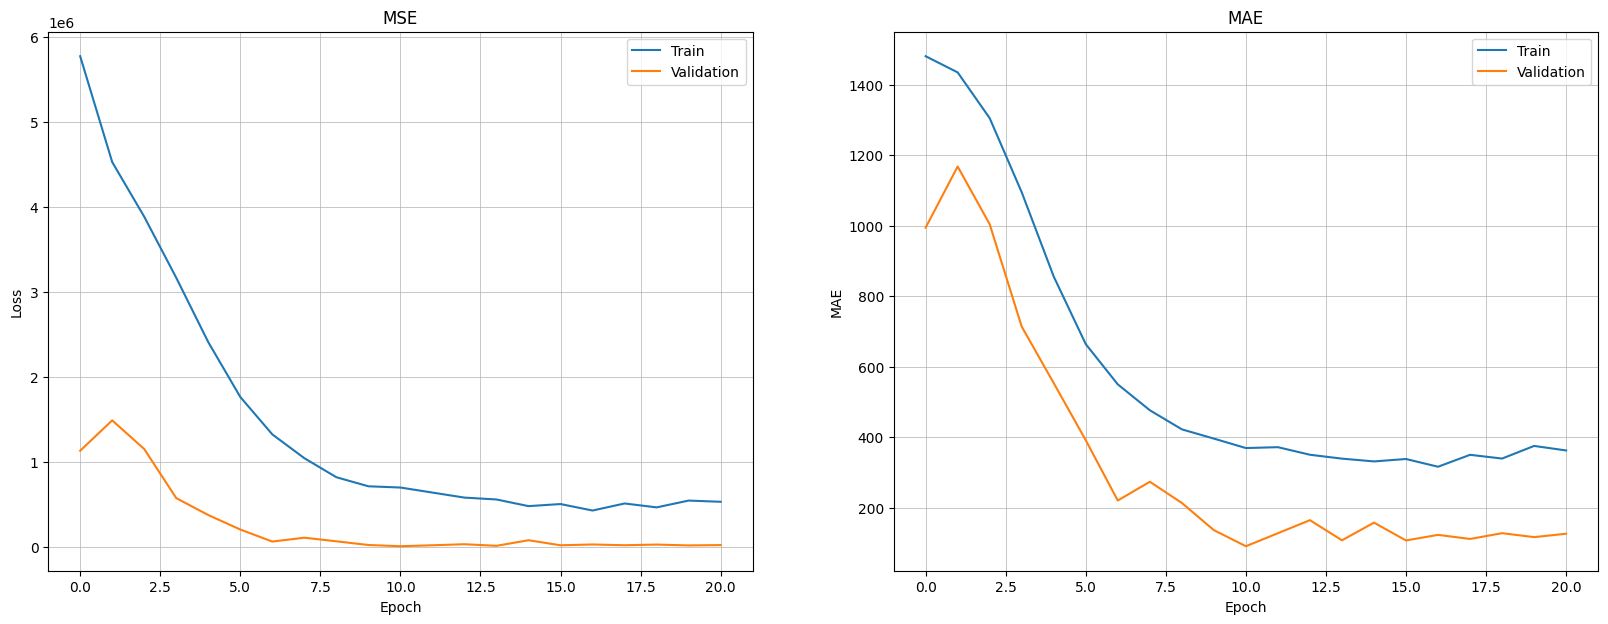

In [685]:
plot_history(history)

# Setup code for learning curves

In [686]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [687]:
model.save("univariate model"
)

2022-11-23 19:57:50.830108: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: univariate model/assets


INFO:tensorflow:Assets written to: univariate model/assets
